<a href="https://colab.research.google.com/github/jessicaguo07/DL-Model-NLP-Disaster-Tweets/blob/main/ECE1513Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Jing Guo; Student Number:1010136210

Link: https://colab.research.google.com/drive/1hgtKJfdG_4oVcCvz4oi0cj0_P9vU7-5R#scrollTo=FTG7213CpIyH

In [ ]:
# load standard modules/libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# load special modules/libraries
import os
import warnings
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from collections import Counter
import string
import re
from tqdm  import tqdm

# load pytorch modules/libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,TensorDataset,DataLoader

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import itertools

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_content = os.listdir('/content/drive/My Drive/ColabNotebooks/nlp-getting-started')
print(drive_content)

Mounted at /content/drive
['train.csv', 'test.csv', 'sample_submission.csv']


In [ ]:
file_path_train = '/content/drive/My Drive/ColabNotebooks/nlp-getting-started/train.csv'
df_train = pd.read_csv(file_path_train)
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB


In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# processi nto data and labels
X = df_train['text'].values
y = df_train['target'].values

In [ ]:
# TO BE COMPLETED
positive_indices = np.where(y == 1)[0][:5]
print(X[positive_indices])
print('\n')
negative_indices = np.where(y == 0)[0][:5]
print(X[negative_indices])

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']


["What's up man?" 'I love fruits' 'Summer is lovely' 'My car is so fast'
 'What a goooooooaaaaaal!!!!!!']


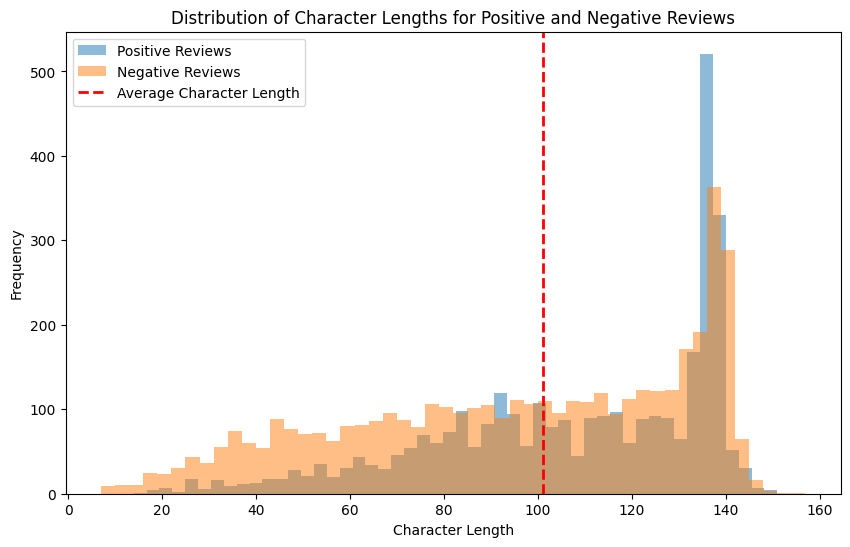

Average Character Length of a Review: 101.04 characters
Average Character Length of a Positive Review: 108.11
Average Character Length of a Negtive Review: 95.71
Minimum Character Length: 7 characters
Maximum Character Length: 157 characters
Number of Positive Reviews: 3271
Number of Negative Reviews: 4342


In [ ]:
# Calculate the character length of positive and negative reviews
df_train['review_char_length'] = df_train['text'].apply(len)

average_char_length = df_train['review_char_length'].mean()
min_char_length = df_train['review_char_length'].min()
max_char_length = df_train['review_char_length'].max()

positive_reviews = df_train[df_train['target'] == 1]
negative_reviews = df_train[df_train['target'] == 0]

average_positive_char_length = positive_reviews['review_char_length'].mean()
average_negtive_char_length = negative_reviews['review_char_length'].mean()

num_positive_reviews = len(positive_reviews)
num_negative_reviews = len(negative_reviews)

# Generate a histogram
plt.figure(figsize=(10, 6))
plt.hist(positive_reviews['review_char_length'], bins=50, alpha=0.5, label='Positive Reviews')
plt.hist(negative_reviews['review_char_length'], bins=50, alpha=0.5, label='Negative Reviews')
plt.axvline(average_char_length, color='red', linestyle='dashed', linewidth=2, label='Average Character Length')
plt.title('Distribution of Character Lengths for Positive and Negative Reviews')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print result
print(f"Average Character Length of a Review: {average_char_length:.2f} characters")
print(f"Average Character Length of a Positive Review: {average_positive_char_length:.2f}")
print(f"Average Character Length of a Negtive Review: {average_negtive_char_length:.2f}")
print(f"Minimum Character Length: {min_char_length} characters")
print(f"Maximum Character Length: {max_char_length} characters")
print(f"Number of Positive Reviews: {num_positive_reviews}")
print(f"Number of Negative Reviews: {num_negative_reviews}")


In [ ]:
# Process the data
# Cleaning a given string stadndardize the words input and remove the non-characteristics.
def preprocess_string(str1):
    # remove all non-word characters excluding number and letters
    str1= re.sub(r"[^\w\s]",'',str1)
    # remove all whitespace with no space
    str1= re.sub(r"\s",'',str1)
    # replace digits with no space
    str1= re.sub(r"\d",'',str1)
    return str1

# Remove stop words
def preprocess_sentence(sen1):
    word_list=[]
    stop_word = set(stopwords.words("english"))
    for word in sen1.lower().split():
        word = preprocess_string(word)
        if word not in stop_word and word!='':
            word_list.append(word)
    return word_list

# Creates a vocabulary that only include the most important words
def get_stoi(data):
    word_list=[]
    for review in data:
        word_list.extend(preprocess_sentence(review))
    corpus = Counter(word_list)
    print(corpus.get)
    # sorting on the basis of most common words
    corpus_ =sorted(corpus,key= corpus.get,reverse=True)[:1000]
    # creating a dict
    stoi =  {ch:i+1 for i,ch in enumerate(corpus_)}
    return stoi

# Tokenize setence
def tokenize(data, labels, stoi):
    # tokenize
    data_encoded = []
    for review in data:
        data_encoded.append([stoi[word] for word in preprocess_sentence(review)
                                     if word in stoi.keys()])
    return np.array(data_encoded), np.array(labels)

# Create uniform length for each review
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review)!=0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [ ]:
def PreparedTrain(traindatasetX, datasetX, datasety, padding=150):
    # Get vocabulary (stoi) using the training dataset
    stoi = get_stoi(traindatasetX)

    # Tokenize
    datasetX_encoded, datasety_encoded = tokenize(datasetX, datasety, stoi)
    datasetX_padded = padding_(datasetX_encoded, padding)

    return datasetX_padded, datasety_encoded
# Split the dataset into train, validation, and test sets (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# training/validate/test set
X_train_padded, y_train_encoded = PreparedTrain(X_train, X_train, y_train)
X_valid_padded, y_valid_encoded = PreparedTrain(X_train, X_valid, y_valid)
X_test_padded, y_test_encoded = PreparedTrain(X_train, X_test, y_test)

<built-in method get of Counter object at 0x7ac0774571a0>


<ipython-input-42-b7d4740489f7>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels)


<built-in method get of Counter object at 0x7ac0774faf70>
<built-in method get of Counter object at 0x7ac0774aafc0>


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
train_dataset = CustomDataset(X_train_padded, y_train_encoded)
valid_dataset = CustomDataset(X_valid_padded, y_valid_encoded)
test_dataset = CustomDataset(X_test_padded, y_test_encoded)

In [ ]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Print the size of the dataloader
for batch_idx, (batch_X, batch_y) in enumerate(train_dataloader):
    print(f"Batch Index: {batch_idx}")
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)
    break
# Print total number of batches
print("Total Batches:", len(train_dataloader))

Batch Index: 0
Batch X shape: torch.Size([16, 150])
Batch y shape: torch.Size([16])
Total Batches: 286


In [ ]:
# RNN Model an embedding layer (with size embedding dim) followed by
# an RNN layer and a fully connected layer.
class SentimentRNNCon(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(SentimentRNNCon, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

In [ ]:
# Calculate Accuracy
def get_accuracy(model, data, device='cpu'):
    """ Compute the accuracy of the `model` across a dataset `data` """
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():  # To reduce memory consumption
        for tweets, labels in data:
            tweets, labels = tweets.to(device), labels.to(device)
            output = model(tweets)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += labels.shape[0]
    model.train()
    return correct / total

In [ ]:
# Calculate F1 Score
def get_f1_score(model, data, device='cpu'):
    """ Compute the F1 score of the `model` across a dataset `data` """
    model.eval()
    true_labels, predicted_labels = [], []

    with torch.no_grad():  # To reduce memory consumption
        for tweets, labels in data:
            tweets, labels = tweets.to(device), labels.to(device)
            output = model(tweets)
            pred = output.max(1, keepdim=True)[1]

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(pred.cpu().numpy().flatten())

    model.train()

    f1 = f1_score(true_labels, predicted_labels)
    return f1

In [ ]:
# Train fucntion hyperparameter: learning rate, number of epochs
def train_rnn_networkS(model, train, valid, num_epochs=5, learning_rate=1e-5, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc, train_f1, valid_f1 = [], [], [], [], [], []
    epochs = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_train_loss = 0.0
        train_preds, train_labels = [], []

        for tweets, labels in train:
            tweets, labels = tweets.to(device), labels.to(device)  # Move to GPU if using

            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            train_preds.extend(pred.argmax(dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        epoch_train_loss /= len(train)
        train_losses.append(epoch_train_loss)
        epochs.append(epoch)

        train_f1_score = f1_score(train_labels, train_preds, average='macro')
        train_f1.append(train_f1_score)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        epoch_valid_loss = 0.0
        valid_preds, valid_labels = [], []

        with torch.no_grad():
            for tweets, labels in valid:
                tweets, labels = tweets.to(device), labels.to(device)
                output = model(tweets)
                loss = criterion(output, labels)
                epoch_valid_loss += loss.item()

                valid_preds.extend(output.argmax(dim=1).cpu().numpy())
                valid_labels.extend(labels.cpu().numpy())

        epoch_valid_loss /= len(valid)
        valid_losses.append(epoch_valid_loss)

        valid_f1_score = f1_score(valid_labels, valid_preds, average='macro')
        valid_f1.append(valid_f1_score)

        train_acc.append(get_accuracy(model, train, device))
        valid_acc.append(get_accuracy(model, valid, device))

        print(f"Epoch {epoch+1}; Train Loss {epoch_train_loss:.6f}; Valid Loss {epoch_valid_loss:.6f}; "
              f"Train Acc {train_acc[-1]:.6f}; Val Acc {valid_acc[-1]:.6f}; Train F1 {train_f1[-1]:.6f}; Val F1 {valid_f1[-1]:.6f}")

        model_checkpoint_path = '/content/drive/My Drive/ColabNotebooks/new'
        model_checkpoint_file = os.path.join(model_checkpoint_path, f'bestmodel=model_epoch{epoch + 1}')
        torch.save(model.state_dict(), f"{model_checkpoint_file}.pt")
        print(f"Saved model checkpoint: {model_checkpoint_file}")
        torch.cuda.empty_cache()
    # Plotting Loss
    plt.title("Training and Validation Loss")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    # Plotting Accuracy
    plt.title("Training and Validation Accuracy")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # Plotting F1
    plt.title("Training and Validation F1")
    plt.plot(epochs, train_f1, label="Train")
    plt.plot(epochs, valid_f1, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.legend(loc='best')
    plt.show()



<built-in method get of Counter object at 0x7ac0774f3920>
Epoch 1; Train Loss 0.668832; Valid Loss 0.651757; Train Acc 0.653383; Val Acc 0.655286; Train F1 0.540001; Val F1 0.640387
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch1
Epoch 2; Train Loss 0.627024; Valid Loss 0.608555; Train Acc 0.719728; Val Acc 0.713723; Train F1 0.652801; Val F1 0.707335
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch2
Epoch 3; Train Loss 0.562544; Valid Loss 0.552337; Train Acc 0.772279; Val Acc 0.738674; Train F1 0.728227; Val F1 0.721422
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch3
Epoch 4; Train Loss 0.488378; Valid Loss 0.500527; Train Acc 0.811036; Val Acc 0.758372; Train F1 0.765448; Val F1 0.751626
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch4
Epoch 5; Train Loss 0.430922; Valid Loss 0.484316; Train Acc 0.839282; Val Acc 0.77281

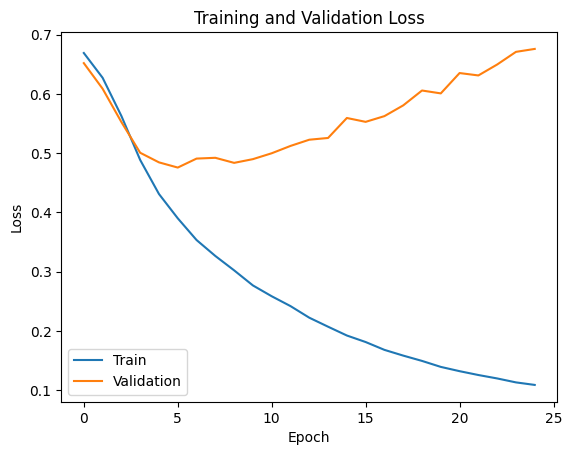

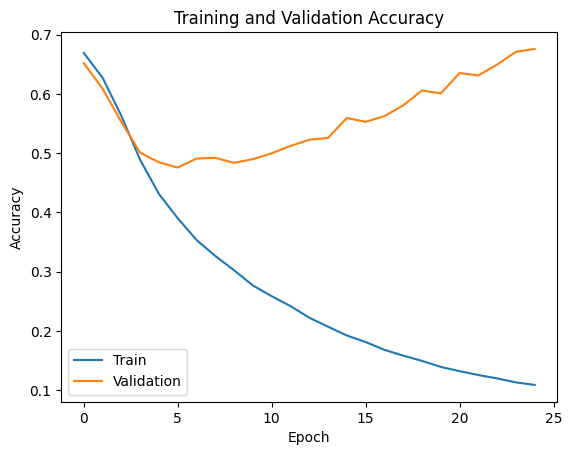

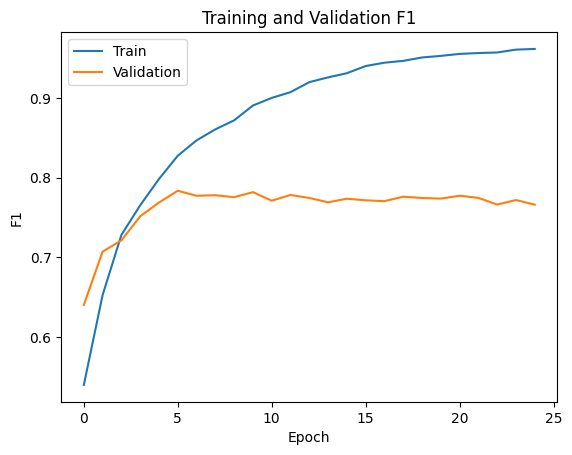

In [ ]:
#  With Maxpooling; Emembedding_dim: 100; hiden layer: 30; learning rate 0.0005
stoi = get_stoi(X_train)
model = SentimentRNNCon(len(stoi)+1,100,30,2)
train_rnn_networkS(model,train_dataloader, valid_dataloader,num_epochs=25, learning_rate=0.0005)

Epoch 1; Train Loss 0.674371; Valid Loss 0.669471; Train Acc 0.620539; Val Acc 0.597505; Train F1 0.531088; Val F1 0.540118
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch1
Epoch 2; Train Loss 0.647427; Valid Loss 0.651728; Train Acc 0.680315; Val Acc 0.632305; Train F1 0.606801; Val F1 0.618570
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch2
Epoch 3; Train Loss 0.613179; Valid Loss 0.622751; Train Acc 0.724108; Val Acc 0.647406; Train F1 0.673630; Val F1 0.640439
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch3
Epoch 4; Train Loss 0.558206; Valid Loss 0.585310; Train Acc 0.773593; Val Acc 0.705187; Train F1 0.734844; Val F1 0.692445
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch4
Epoch 5; Train Loss 0.502413; Valid Loss 0.545810; Train Acc 0.800526; Val Acc 0.727511; Train F1 0.765362; Val F1 0.720453
Saved model checkpoi

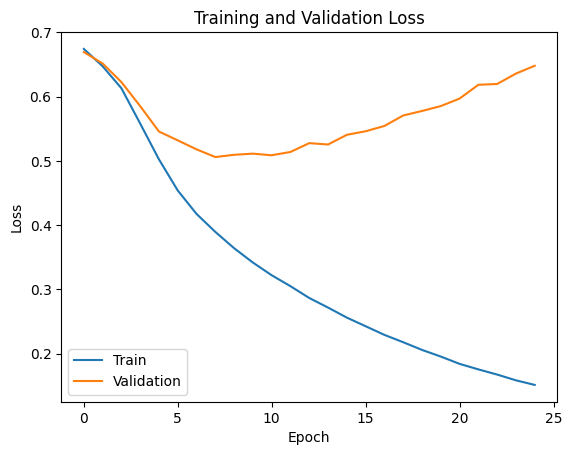

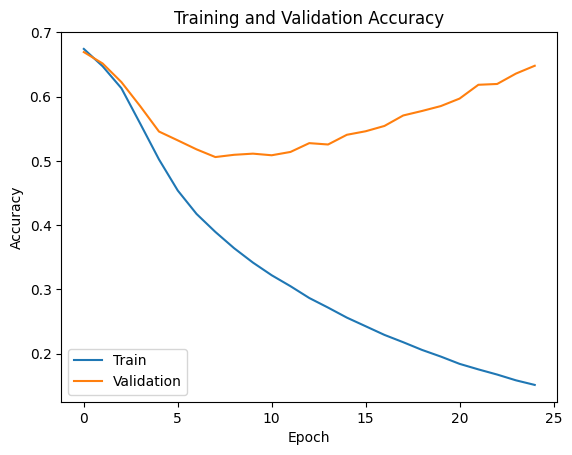

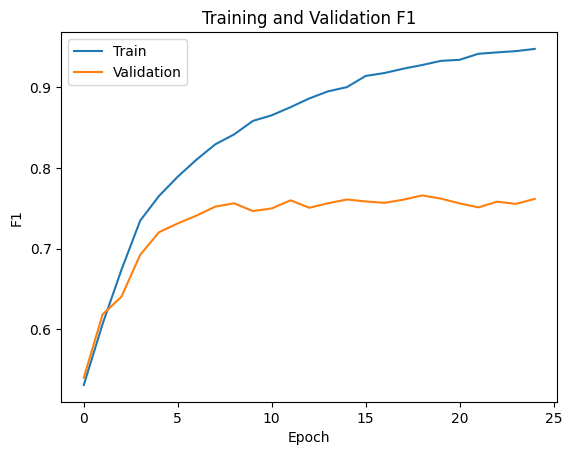

In [ ]:
#  With Maxpooling; Emembedding_dim: 100; hiden layer: 20; learning rate 0.0005
model = SentimentRNNCon(len(stoi)+1,80,20,2)
train_rnn_networkS(model,train_dataloader, valid_dataloader,num_epochs=25, learning_rate=0.0005)

Epoch 1; Train Loss 0.677689; Valid Loss 0.667491; Train Acc 0.590541; Val Acc 0.573867; Train F1 0.515378; Val F1 0.434536
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch1
Epoch 2; Train Loss 0.642524; Valid Loss 0.634707; Train Acc 0.721918; Val Acc 0.661852; Train F1 0.591753; Val F1 0.651212
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch2
Epoch 3; Train Loss 0.578972; Valid Loss 0.577756; Train Acc 0.771623; Val Acc 0.696651; Train F1 0.713956; Val F1 0.691700
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch3
Epoch 4; Train Loss 0.504524; Valid Loss 0.540084; Train Acc 0.812787; Val Acc 0.735391; Train F1 0.766955; Val F1 0.729324
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch4
Epoch 5; Train Loss 0.448706; Valid Loss 0.517067; Train Acc 0.837311; Val Acc 0.745896; Train F1 0.799260; Val F1 0.740875
Saved model checkpoi

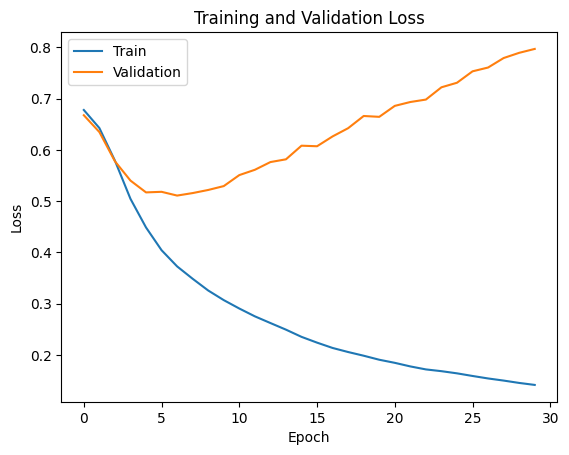

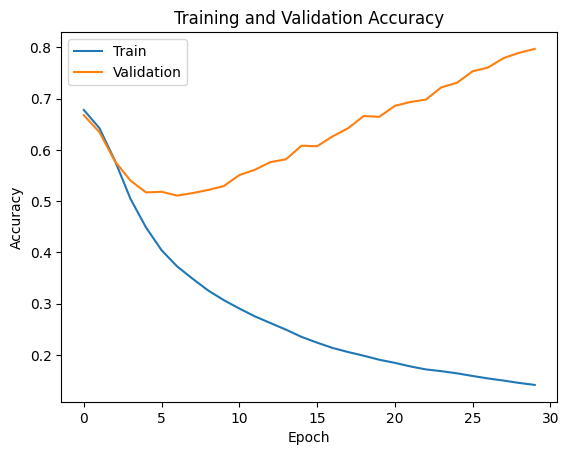

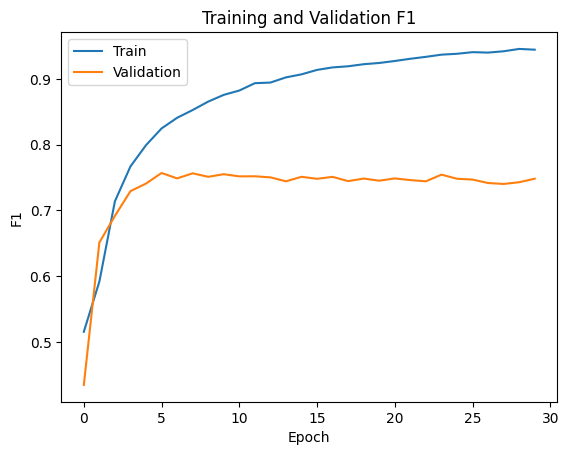

In [ ]:
#  With Maxpooling; Emembedding_dim: 100; hiden layer: 10; learning rate 0.001
model = SentimentRNNCon(len(stoi)+1,100,10,2)
train_rnn_networkS(model,train_dataloader, valid_dataloader,num_epochs=30, learning_rate=0.001)

In [ ]:
# Best RNN
best_model = SentimentRNNCon(len(stoi)+1,100,30,2)
best_model.load_state_dict(torch.load('/content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch67885.pt'))

<All keys matched successfully>

In [ ]:
# Final Test result for RNN model
print("Test Acc %f;" % (get_accuracy(best_model, test_dataloader)))
print("Test F1 %f;" % (get_f1_score(best_model, test_dataloader)))

Test Acc 0.755745;
Test F1 0.670796;


In [ ]:
# Bi-direction LSTM model
class SentimentBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(SentimentBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        # Use BiLSTM instead of RNN
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)
        # Adjust the input size of the fully connected layer
        self.fc = nn.Linear(hidden_size * 2 * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(2, x.size(0), self.hidden_size)  # Initial hidden state
        c0 = torch.zeros(2, x.size(0), self.hidden_size)  # Initial cell state

        out, _ = self.lstm(x, (h0, c0))
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

Epoch 1; Train Loss 0.663300; Valid Loss 0.630475; Train Acc 0.679877; Val Acc 0.663821; Train F1 0.533561; Val F1 0.594156
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch1
Epoch 2; Train Loss 0.579195; Valid Loss 0.537590; Train Acc 0.780381; Val Acc 0.734077; Train F1 0.704625; Val F1 0.718340
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch2
Epoch 3; Train Loss 0.481536; Valid Loss 0.477171; Train Acc 0.825706; Val Acc 0.774130; Train F1 0.779354; Val F1 0.768998
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch3
Epoch 4; Train Loss 0.415023; Valid Loss 0.457480; Train Acc 0.850230; Val Acc 0.787919; Train F1 0.814329; Val F1 0.780717
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch4
Epoch 5; Train Loss 0.369301; Valid Loss 0.456800; Train Acc 0.869937; Val Acc 0.791858; Train F1 0.839064; Val F1 0.783687
Saved model checkpoi

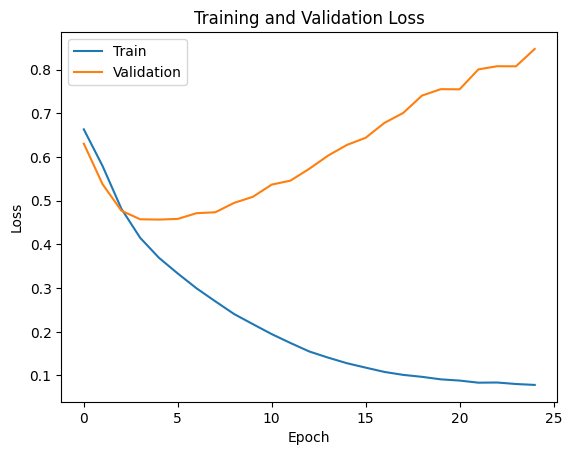

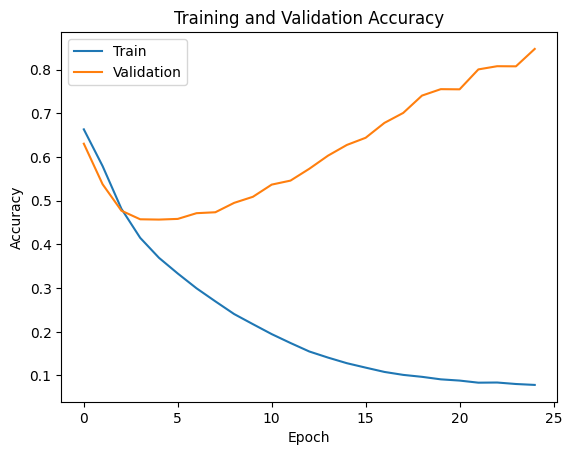

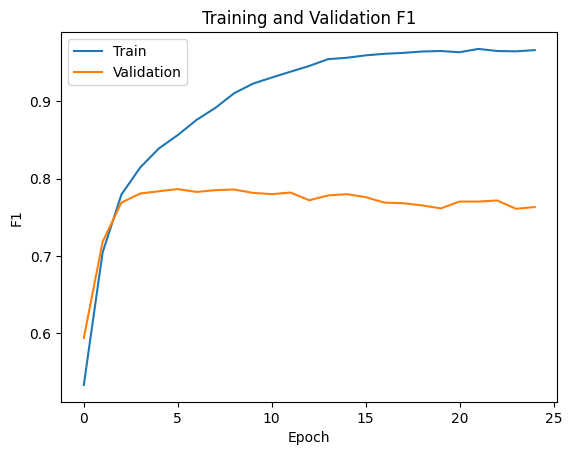

In [ ]:
#  With Maxpooling; Emembedding_dim: 100; hiden layer: 30; learning rate 0.0005
model1 = SentimentBiLSTM(len(stoi)+1,100,30,2)
train_rnn_networkS(model1,train_dataloader, valid_dataloader,num_epochs=25, learning_rate=0.0005 )

Epoch 1; Train Loss 0.679849; Valid Loss 0.669701; Train Acc 0.568426; Val Acc 0.564018; Train F1 0.392514; Val F1 0.377924
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch1
Epoch 2; Train Loss 0.658567; Valid Loss 0.652229; Train Acc 0.692796; Val Acc 0.682863; Train F1 0.479705; Val F1 0.636484
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch2
Epoch 3; Train Loss 0.634543; Valid Loss 0.625529; Train Acc 0.699365; Val Acc 0.678267; Train F1 0.634996; Val F1 0.619391
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch3
Epoch 4; Train Loss 0.606220; Valid Loss 0.599576; Train Acc 0.768776; Val Acc 0.745240; Train F1 0.699319; Val F1 0.728610
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch4
Epoch 5; Train Loss 0.573742; Valid Loss 0.573130; Train Acc 0.767024; Val Acc 0.734734; Train F1 0.749041; Val F1 0.706944
Saved model checkpoi

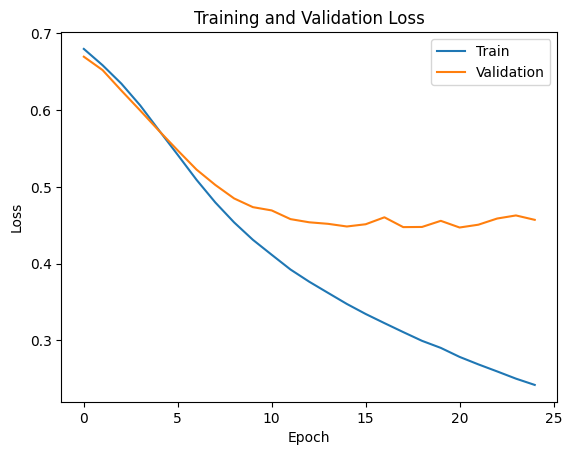

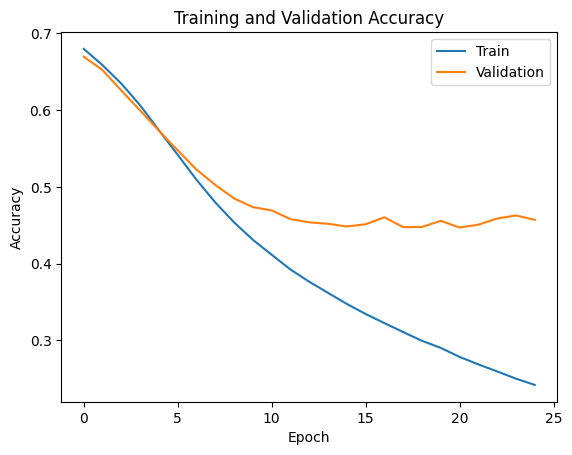

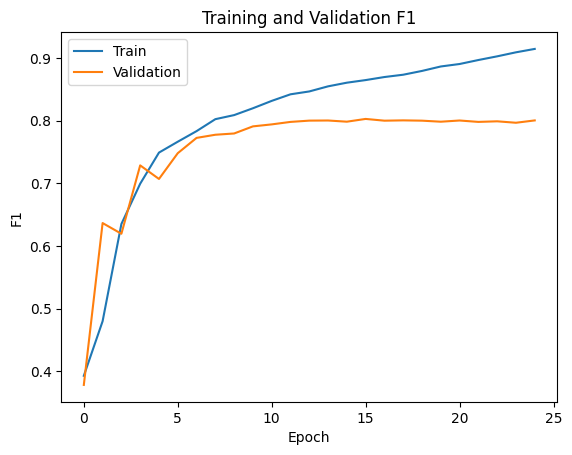

In [ ]:
#  With Maxpooling; Emembedding_dim: 200; hiden layer: 30; learning rate 0.0001
model1 = SentimentBiLSTM(len(stoi)+1,200,30,2)
train_rnn_networkS(model1,train_dataloader, valid_dataloader,num_epochs=25, learning_rate=0.0001 )

Epoch 1; Train Loss 0.683942; Valid Loss 0.668599; Train Acc 0.571491; Val Acc 0.570584; Train F1 0.393410; Val F1 0.389788
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch1
Epoch 2; Train Loss 0.652712; Valid Loss 0.639146; Train Acc 0.684257; Val Acc 0.679580; Train F1 0.523604; Val F1 0.620945
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch2
Epoch 3; Train Loss 0.618206; Valid Loss 0.604328; Train Acc 0.739873; Val Acc 0.716349; Train F1 0.664823; Val F1 0.678756
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch3
Epoch 4; Train Loss 0.578182; Valid Loss 0.573607; Train Acc 0.762864; Val Acc 0.734734; Train F1 0.734020; Val F1 0.705344
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch4
Epoch 5; Train Loss 0.537332; Valid Loss 0.541190; Train Acc 0.795708; Val Acc 0.763624; Train F1 0.767393; Val F1 0.746205
Saved model checkpoi

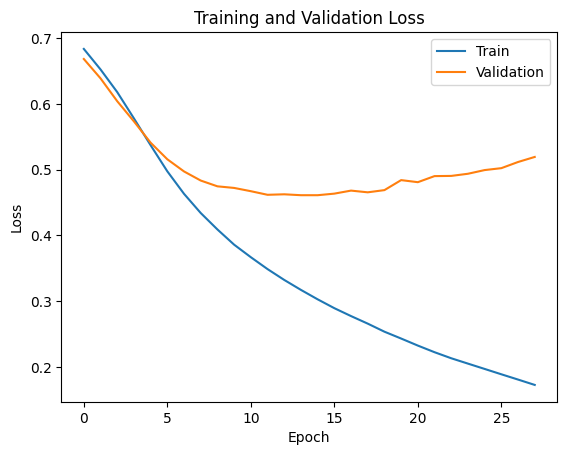

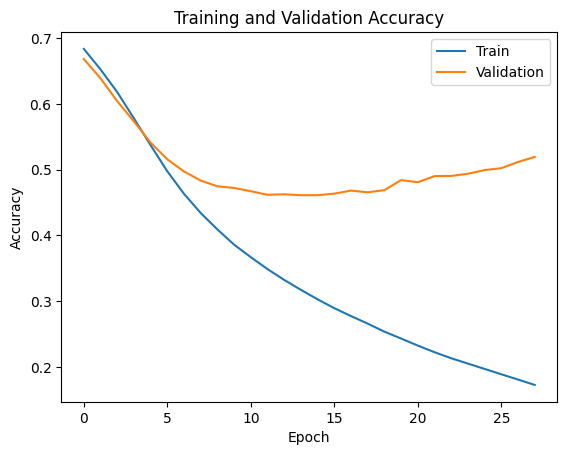

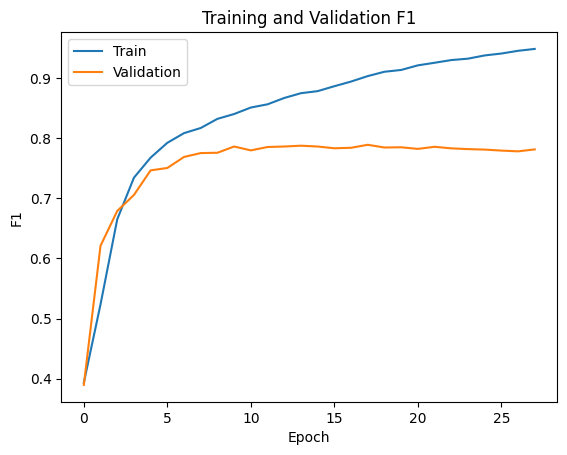

In [ ]:
#  With Maxpooling; Emembedding_dim: 200; hiden layer: 15; learning rate 0.0002
model1 = SentimentBiLSTM(len(stoi)+1,200,15,2)
train_rnn_networkS(model1,train_dataloader, valid_dataloader,num_epochs=28, learning_rate=0.0002 )

Epoch 1; Train Loss 0.658120; Valid Loss 0.629558; Train Acc 0.711846; Val Acc 0.701904; Train F1 0.536957; Val F1 0.689107
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch1
Epoch 2; Train Loss 0.595715; Valid Loss 0.565471; Train Acc 0.765492; Val Acc 0.741300; Train F1 0.699538; Val F1 0.722236
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch2
Epoch 3; Train Loss 0.522364; Valid Loss 0.511665; Train Acc 0.804905; Val Acc 0.760998; Train F1 0.753627; Val F1 0.750875
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch3
Epoch 4; Train Loss 0.459060; Valid Loss 0.478305; Train Acc 0.827020; Val Acc 0.783322; Train F1 0.795493; Val F1 0.774020
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch4
Epoch 5; Train Loss 0.409635; Valid Loss 0.471261; Train Acc 0.833589; Val Acc 0.780039; Train F1 0.819433; Val F1 0.765272
Saved model checkpoi

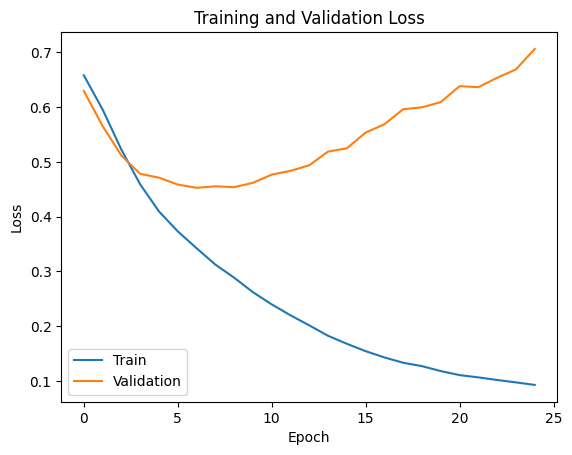

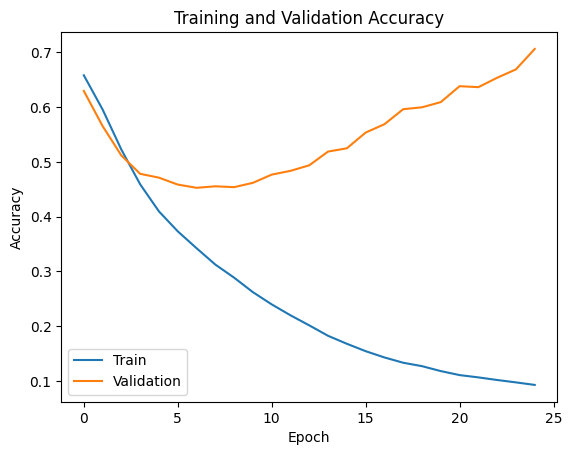

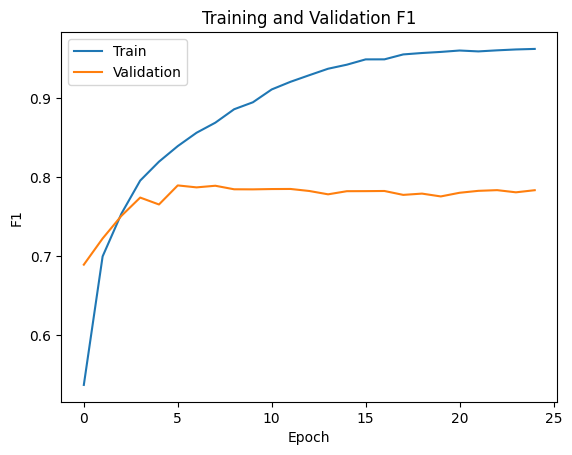

In [ ]:
#  With Maxpooling; Emembedding_dim: 200; hiden layer: 50; learning rate 0.0002
model1 = SentimentBiLSTM(len(stoi)+1,200,50,2)
train_rnn_networkS(model1,train_dataloader, valid_dataloader,num_epochs=25, learning_rate=0.0002 )

In [ ]:
# Best Bi-direction LSTM model
stoi = get_stoi(X_train)
best_modelBi = SentimentBiLSTM(len(stoi)+1,200,30,2)
best_modelBi.load_state_dict(torch.load('/content/drive/My Drive/ColabNotebooks/new/bestmodel=200302model_epoch168089.pt'))

<built-in method get of Counter object at 0x7ac077277920>


<All keys matched successfully>

In [ ]:
# Final Test result for Bi-direction LSTM model
print("Test Acc %f;" % (get_accuracy(best_modelBi, test_dataloader)))
print("Test F1 %f;" % (get_f1_score(best_modelBi, test_dataloader)))

Test Acc 0.780696;
Test F1 0.690741;


# Transfer Learning Bert Model


In [ ]:
# install relevant libraries
!pip install -qq transformers

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
# Process data to remove the non-word characters
def preprocess_string(str1):
    # remove all non-word characters excluding number and letters
    str1= re.sub(r"[^\w\s]",'',str1)
    # remove all whitespace with no space
    str1= re.sub(r"\s",'',str1)
    # replace digits with no space
    str1= re.sub(r"\d",'',str1)
    return str1
def preprocess_sentence(sen1):
    word_list = []
    stop_words = set(stopwords.words("english"))
    for word in sen1.lower().split():
        word = preprocess_string(word)
        if word not in stop_words and word != '' and len(word) > 2 and not word.startswith(("http", "https")):
            word_list.append(word)
    return word_list
def join_words_preprocess(sen1):
    word_list = preprocess_sentence(sen1)
    return ' '.join(word_list)

In [ ]:
# Data processing
class MovieReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# Apply data processing
df_2 = df_train
df_2['text'] = df_2['text'].apply(join_words_preprocess)

In [ ]:
# Calculate the character length of positive and negative reviews
df_2['review_char_length'] = df_train['text'].apply(len)

average_char_length = df_2['review_char_length'].mean()
min_char_length = df_2['review_char_length'].min()
max_char_length = df_2['review_char_length'].max()

positive_reviews = df_2[df_2['target'] == 1]
negative_reviews = df_2[df_2['target'] == 0]

average_positive_char_length = positive_reviews['review_char_length'].mean()
average_negtive_char_length = negative_reviews['review_char_length'].mean()

num_positive_reviews = len(positive_reviews)
num_negative_reviews = len(negative_reviews)

# Print result
print(f"Average Character Length of a Review: {average_char_length:.2f} characters")
print(f"Average Character Length of a Positive Review: {average_positive_char_length:.2f}")
print(f"Average Character Length of a Negtive Review: {average_negtive_char_length:.2f}")
print(f"Minimum Character Length: {min_char_length} characters")
print(f"Maximum Character Length: {max_char_length} characters")
print(f"Number of Positive Reviews: {num_positive_reviews}")
print(f"Number of Negative Reviews: {num_negative_reviews}")


Average Character Length of a Review: 63.18 characters
Average Character Length of a Positive Review: 67.76
Average Character Length of a Negtive Review: 59.73
Minimum Character Length: 3 characters
Maximum Character Length: 138 characters
Number of Positive Reviews: 3271
Number of Negative Reviews: 4342


In [ ]:
X_pro = df_2['text'].values
y = df_2['target'].values
X_train, X_temp, y_train, y_temp = train_test_split(X_pro, y, test_size=0.7, random_state=1)
X_valid, X_temp2, y_valid, y_temp2 = train_test_split(X_temp, y_temp, test_size=0.9, random_state=1)
X_temp2, X_test, y_temp2, y_test = train_test_split(X_temp, y_temp, test_size=0.88, random_state=1)

In [ ]:
# prepare data loaders
MAX_LEN = 138
BATCH_SIZE = 10

#training data
train_data = MovieReviewDataset(reviews=X_train,
                                targets=y_train,
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)

train_data_loader = DataLoader(train_data, batch_size = BATCH_SIZE, num_workers = 1)

#validation data

valid_data = MovieReviewDataset(reviews=X_valid,
                                targets=y_valid,
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)

valid_data_loader = DataLoader(valid_data, batch_size = BATCH_SIZE, num_workers = 1)
#test data

test_data = MovieReviewDataset(reviews=X_test,
                                targets=y_test,
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)

test_data_loader = DataLoader(test_data, batch_size = BATCH_SIZE, num_workers = 1)


In [ ]:
# Top words in the review
def get_top_tokens(data_loader, tokenizer, num_tokens=5):
    all_tokens = []
    for batch in data_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']

        # Mask out the PAD tokens before flattening
        input_ids = input_ids[attention_mask == 1]

        all_tokens.extend(input_ids.flatten().numpy())

    token_counts = Counter(all_tokens)

    if tokenizer.pad_token_id in token_counts:
        del token_counts[tokenizer.pad_token_id]

    top_tokens = token_counts.most_common(num_tokens + 50)

    top_tokens_final = []
    for token, count in top_tokens:
        token_str = tokenizer.convert_ids_to_tokens([token])[0]
        # Exclude subwords and specific tokens
        if token_str.startswith(("##", "[")) or len(token_str) < 3:
            continue
        top_tokens_final.append((token_str, count))
    return top_tokens_final[:num_tokens]
top_tokens_train = get_top_tokens(train_data_loader, tokenizer, num_tokens=5)
print("Top 5 occurring tokens in the training dataset:")
for token, count in top_tokens_train:
    print(f"Token: {token}, Count: {count}")

Top 5 occurring tokens in the training dataset:
Token: like, Count: 206
Token: fire, Count: 156
Token: new, Count: 152
Token: don, Count: 146
Token: get, Count: 139


In [ ]:
# Bert Model
class SentimentClassifierPooled(nn.Module):
    def __init__(self, hiden_size, n_classes):
        super(SentimentClassifierPooled, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

        # TO BE COMPLETED
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
        #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.fc1 = nn.Linear(768, hiden_size)
        self.fc2 = nn.Linear(hiden_size, n_classes)
        self.name = "SentimentClassifierPooled"

    def forward(self, input_ids, attention_mask):

        pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[1]
        # TO BE COMPLETED
        output = self.dropout(pooled_output)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)
        output = F.softmax(output, dim=1)
        return output

In [ ]:
# Calculate accuracy for Bert Model
def get_accuracy(model, dataset, device='cpu'):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for data in dataset:
            tweets = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['targets'].to(device)

            outputs = model(tweets, attention_mask=attention_mask)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_samples += targets.size(0)

    accuracy = correct_predictions / total_samples
    model.train()
    return accuracy

In [ ]:
# Calculate f1 score for Bert
def get_f1_score(model, dataset, device='cpu'):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for data in dataset:
            tweets = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['targets'].to(device)

            outputs = model(tweets, attention_mask=attention_mask)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    f1 = f1_score(all_targets, all_predictions, average='macro')
    model.train()
    return f1


In [ ]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc, train_f1, valid_f1 = [], [], [], [], [], []
    epochs = []

    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        train_preds, train_labels = [], []

        for batch in train:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs, attention_mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            train_labels.extend(targets.cpu().numpy())

        epoch_train_loss /= len(train)
        train_losses.append(epoch_train_loss)
        epochs.append(epoch)

        train_f1_score = f1_score(train_labels, train_preds, average='macro')
        train_f1.append(train_f1_score)

        model.eval()  # Set model to evaluation mode
        epoch_valid_loss = 0.0
        valid_preds, valid_labels = [], []

        with torch.no_grad():
            for batch_v in valid:
                inputs_v = batch_v['input_ids'].to(device)
                attention_mask_v = batch_v['attention_mask'].to(device)
                labels_v = batch_v['targets'].to(device)

                output_v = model(inputs_v, attention_mask_v)
                loss_v = criterion(output_v, labels_v)
                epoch_valid_loss += loss_v.item()

                valid_preds.extend(output_v.argmax(dim=1).cpu().numpy())
                valid_labels.extend(labels_v.cpu().numpy())

        epoch_valid_loss /= len(valid)
        valid_losses.append(epoch_valid_loss)

        valid_f1_score = f1_score(valid_labels, valid_preds, average='macro')
        valid_f1.append(valid_f1_score)

        train_acc.append(get_accuracy(model, train, device))
        valid_acc.append(get_accuracy(model, valid, device))

        print(f"Epoch {epoch+1}; Train Loss {epoch_train_loss:.6f}; Valid Loss {epoch_valid_loss:.6f}; "
              f"Train Acc {train_acc[-1]:.6f}; Val Acc {valid_acc[-1]:.6f}; Train F1 {train_f1[-1]:.6f}; Val F1 {valid_f1[-1]:.6f}")

        model_checkpoint_path = '/content/drive/My Drive/ColabNotebooks/new'
        model_checkpoint_file = os.path.join(model_checkpoint_path, f'bestmodel=model_epoch{epoch + 1}.pth')
        torch.save(model.state_dict(), f"{model_checkpoint_file}.pt")
        print(f"Saved model checkpoint: {model_checkpoint_file}")
        torch.cuda.empty_cache()
    # Plotting Loss
    plt.title("Training and Validation Loss")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    # Plotting Accuracy
    plt.title("Training and Validation Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # Plotting F1
    plt.title("Training and Validation F1 score")
    plt.plot(epochs, train_f1, label="Train")
    plt.plot(epochs, valid_f1, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("F1 score")
    plt.legend(loc='best')
    plt.show()


Epoch 1; Train Loss 0.604115; Valid Loss 0.563129; Train Acc 0.765659; Val Acc 0.752345; Train F1 0.705491; Val F1 0.720863
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch1.pth
Epoch 2; Train Loss 0.506812; Valid Loss 0.513932; Train Acc 0.855453; Val Acc 0.795497; Train F1 0.810366; Val F1 0.791696
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch2.pth
Epoch 3; Train Loss 0.476001; Valid Loss 0.502757; Train Acc 0.865966; Val Acc 0.799250; Train F1 0.835889; Val F1 0.791304
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch3.pth
Epoch 4; Train Loss 0.453029; Valid Loss 0.506395; Train Acc 0.888743; Val Acc 0.797373; Train F1 0.857667; Val F1 0.795501
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch4.pth
Epoch 5; Train Loss 0.442097; Valid Loss 0.527324; Train Acc 0.881735; Val Acc 0.787992; Train F1 0.870941; Val F1 0.787801
Save

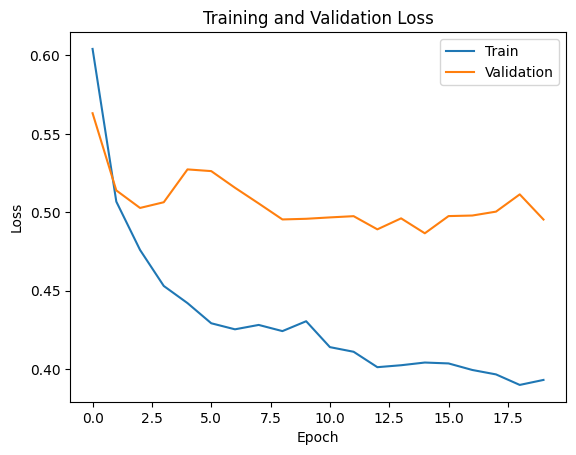

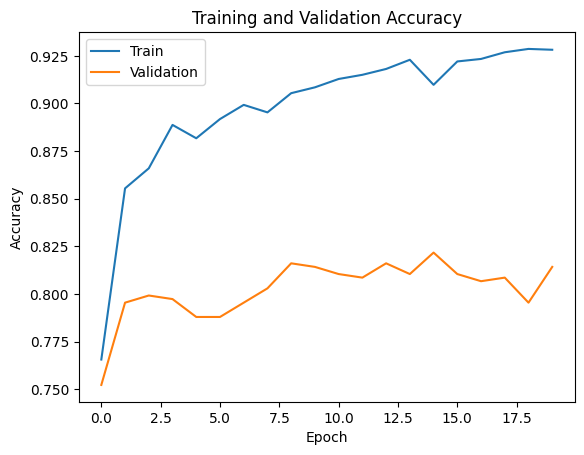

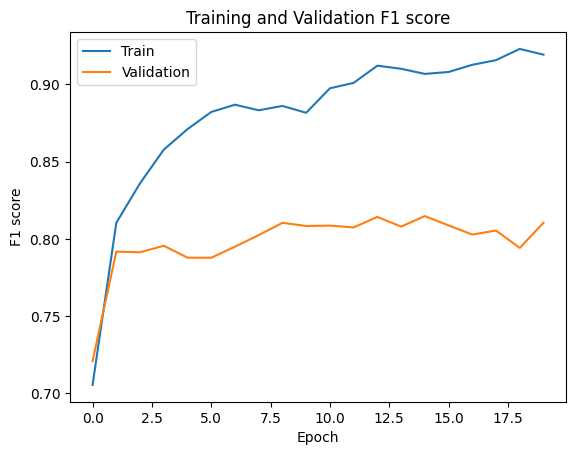

In [ ]:
# With hiden layer: 30; learning rate 0.00001
modelS = SentimentClassifierPooled(30,2)
train_rnn_network(modelS,train_data_loader,valid_data_loader,num_epochs=20,learning_rate=0.00001)

In [ ]:
# With hiden layer: 20; learning rate 0.005
modelS = SentimentClassifierPooled(20,2)
train_rnn_network(modelS,train_data_loader,valid_data_loader,num_epochs=20,learning_rate=0.005)

Epoch 1; Train Loss 0.702108; Valid Loss 0.688710; Train Acc 0.556505; Val Acc 0.555008; Train F1 0.483317; Val F1 0.356917
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch1.pth
Epoch 2; Train Loss 0.688259; Valid Loss 0.686195; Train Acc 0.556505; Val Acc 0.555008; Train F1 0.357535; Val F1 0.356917
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch2.pth
Epoch 3; Train Loss 0.687370; Valid Loss 0.685970; Train Acc 0.556505; Val Acc 0.555008; Train F1 0.357535; Val F1 0.356917
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch3.pth
Epoch 4; Train Loss 0.687287; Valid Loss 0.685938; Train Acc 0.556505; Val Acc 0.555008; Train F1 0.357535; Val F1 0.356917
Saved model checkpoint: /content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch4.pth
Epoch 5; Train Loss 0.687276; Valid Loss 0.685931; Train Acc 0.556505; Val Acc 0.555008; Train F1 0.357535; Val F1 0.356917
Save

In [ ]:
# Best Bert
best_modelsenti = SentimentClassifierPooled(30,2)
best_modelsenti.cuda()
best_modelsenti.load_state_dict(torch.load('/content/drive/My Drive/ColabNotebooks/new/bestmodel=model_epoch158217.pt'))

<All keys matched successfully>

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = best_modelsenti.to(device)
# Test Accuracy
test_accuracy = get_accuracy(model, test_data_loader, device=device)
print("Test Accuracy:", test_accuracy)
# F1 score
test_f1_score = get_f1_score(model, test_data_loader, device=device)
print("Test F1 Score:", test_f1_score)


Test Accuracy: 0.8092091238541889
Test F1 Score: 0.7938093573225795


In [ ]:
%%shell
jupyter nbconvert --execute --to html /content/ECE1513Project.ipynb

[NbConvertApp] Converting notebook /content/ECE1513Project.ipynb to html
